In [26]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

## Importación del dataset ya analizado


In [27]:
df = pd.read_csv('df_scaled.csv')

In [28]:
df['track_popularity'].head()

0    0.617978
1    0.629213
2    0.662921
3    0.550562
4    0.651685
Name: track_popularity, dtype: float64

## Primer modelo de red neuronal

Se realiza un grid search entre varios parametros para definir con cual el modelo performa mejor


In [29]:
import pickle  #


df = pd.read_csv('df_scaled.csv')


numerical_features = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
X = df[numerical_features].values
y = df['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


class MusicNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_rate)  # Dropout 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=dropout_rate)  # Dropout 
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = self.fc3(x)
        return x

# Grid search
learning_rates = [0.001, 0.01]
hidden_sizes = [64, 128]
dropout_rates = [0.3, 0.5]

best_test_loss = float('inf')
best_model = None
test_losses = [] 


for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for dropout_rate in dropout_rates:
            print(f"Training with lr={lr}, hidden_size={hidden_size}, dropout_rate={dropout_rate}")

            
            input_size = X_train.shape[1]
            output_size = 1  
            model = MusicNet(input_size, hidden_size, dropout_rate, output_size)
            loss_fn = nn.MSELoss()  
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

            
            epochs = 20
            for epoch in range(epochs):
                model.train()  
                train_loss = 0
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  
                    y_pred = model(X_batch).squeeze()
                    loss = loss_fn(y_pred, y_batch)
                    loss.backward()        
                    optimizer.step()       
                    train_loss += loss.item()

                avg_train_loss = train_loss / len(train_dataloader)

                
                model.eval()  
                test_loss = 0
                with torch.no_grad():  
                    for X_batch, y_batch in test_dataloader:
                        y_pred = model(X_batch).squeeze()
                        loss = loss_fn(y_pred, y_batch)
                        test_loss += loss.item()

                avg_test_loss = test_loss / len(test_dataloader)
                test_losses.append(avg_test_loss)  
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

                
                scheduler.step(avg_test_loss)

            
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                best_model = model
                print(f"Nuevo mejor modelo encontrado: Test Loss = {best_test_loss:.4f}")

if best_model is not None:
    
    model_save_path = "models/best_musicnet_model.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo y test loss guardado: {model_save_path}")

Training with lr=0.001, hidden_size=64, dropout_rate=0.3


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Train Loss: 0.0568, Test Loss: 0.0382
Epoch 2/20, Train Loss: 0.0422, Test Loss: 0.0374
Epoch 3/20, Train Loss: 0.0402, Test Loss: 0.0380
Epoch 4/20, Train Loss: 0.0388, Test Loss: 0.0373
Epoch 5/20, Train Loss: 0.0384, Test Loss: 0.0384
Epoch 6/20, Train Loss: 0.0381, Test Loss: 0.0373
Epoch 7/20, Train Loss: 0.0378, Test Loss: 0.0372
Epoch 8/20, Train Loss: 0.0377, Test Loss: 0.0374
Epoch 9/20, Train Loss: 0.0376, Test Loss: 0.0372
Epoch 10/20, Train Loss: 0.0375, Test Loss: 0.0373
Epoch 11/20, Train Loss: 0.0376, Test Loss: 0.0372
Epoch 12/20, Train Loss: 0.0375, Test Loss: 0.0374
Epoch 13/20, Train Loss: 0.0375, Test Loss: 0.0371
Epoch 14/20, Train Loss: 0.0374, Test Loss: 0.0371
Epoch 15/20, Train Loss: 0.0374, Test Loss: 0.0372
Epoch 16/20, Train Loss: 0.0374, Test Loss: 0.0373
Epoch 17/20, Train Loss: 0.0374, Test Loss: 0.0372
Epoch 18/20, Train Loss: 0.0374, Test Loss: 0.0370
Epoch 19/20, Train Loss: 0.0374, Test Loss: 0.0371
Epoch 20/20, Train Loss: 0.0373, Test Lo

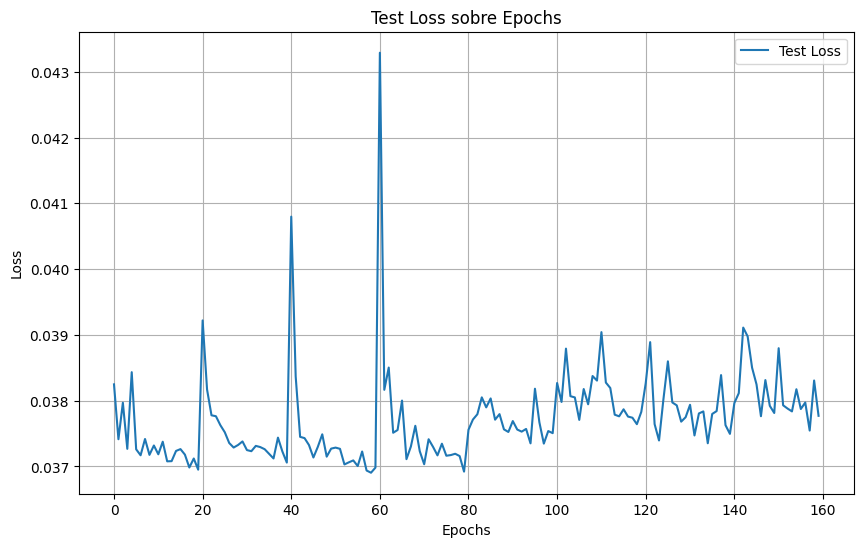

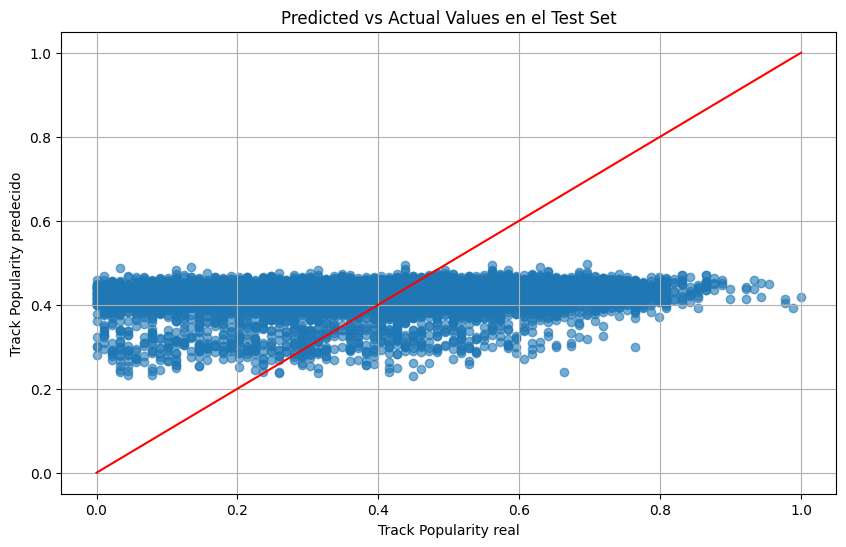

In [30]:



plt.figure(figsize=(10, 6))
plt.plot(test_losses, label="Test Loss")
plt.title("Test Loss sobre Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        y_pred = best_model(X_test_tensor).squeeze().numpy()
        

    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  
    plt.title("Predicted vs Actual Values en el Test Set")
    plt.xlabel("Track Popularity real")
    plt.ylabel("Track Popularity predecido")
    plt.grid(True)
    plt.show()

In [31]:

if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        y_pred = best_model(X_test_tensor).squeeze().numpy()

    # Calcular metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
    r2 = r2_score(y_test, y_pred)

    print(f"MAE de testeo fue: {mae}")
    print(f"RMSE de testeo fue: {rmse}")
    print(f"MAPE de testeo fue: {mape}")
    print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.15881042089650094
RMSE de testeo fue: 0.19220766763089425
MAPE de testeo fue: inf
R2 de testeo fue: 0.04928435607318582


C:\Users\Martin\AppData\Local\Temp\ipykernel_8088\887632112.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


## Segundo modelo de red neuronal

Se trabaja con una menor cantidad de atributos y una red neuronal más simple para visualizar si es posible mantener los resultados pero con una menor complejidad del modelo.


In [32]:

numerical_features_2 = ['acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo']

X = df[numerical_features_2].values
y = df['track_popularity'].values  # Target track_popularity


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
#modelo 2
class MusicNet_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet_2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet_2(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval() 
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss) 
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.22879576683044434
Batch 400, Loss: 0.03827498108148575
Train Loss: 0.0421
Test Loss: 0.0386
Epoch 2
-------------------------------
Batch 0, Loss: 0.046319857239723206
Batch 400, Loss: 0.041733745485544205
Train Loss: 0.0388
Test Loss: 0.0379
Epoch 3
-------------------------------
Batch 0, Loss: 0.04452522099018097
Batch 400, Loss: 0.049250245094299316
Train Loss: 0.0383
Test Loss: 0.0384
Epoch 4
-------------------------------
Batch 0, Loss: 0.03877051919698715
Batch 400, Loss: 0.039006367325782776
Train Loss: 0.0382
Test Loss: 0.0377
Epoch 5
-------------------------------
Batch 0, Loss: 0.030881617218255997
Batch 400, Loss: 0.043942105025053024
Train Loss: 0.0379
Test Loss: 0.0376
Epoch 6
-------------------------------
Batch 0, Loss: 0.030647555366158485
Batch 400, Loss: 0.027820492163300514
Train Loss: 0.0380
Test Loss: 0.0376
Epoch 7
-------------------------------
Batch 0, Loss: 0.04263980686664581
Batch 400, Loss: 0.0430

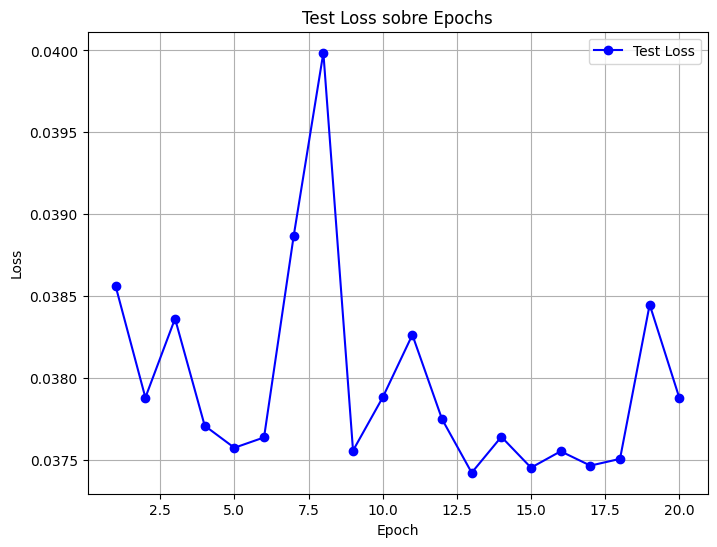

In [34]:
import matplotlib.pyplot as plt


epochs_list = list(range(1, epochs + 1))


plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [35]:

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()

# Calcular metricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.16157815602765446
RMSE de testeo fue: 0.19465701685014572
MAPE de testeo fue: inf
R2 de testeo fue: 0.024899566135138773


C:\Users\Martin\AppData\Local\Temp\ipykernel_8088\952190139.py:8: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [36]:
df_pca = pd.read_csv('df_pca9.csv')

In [37]:
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,track_id,track_popularity
0,-1.228247,-2.007737,0.636795,-1.357469,-1.137151,-1.301107,-0.040412,-0.705792,-0.603308,6f807x0ima9a1j3VPbc7VN,0.617978
1,-0.814656,-1.237786,0.390595,-1.321949,-1.275996,-0.900223,1.379120,0.766448,0.605321,0r7CVbZTWZgbTCYdfa2P31,0.629213
2,-1.380825,-1.835965,0.500640,-1.146859,-1.218530,-1.204166,-0.001245,-0.475784,-0.197209,1z1Hg7Vb0AhHDiEmnDE79l,0.662921
3,-1.276420,-1.840713,1.212820,-0.632802,-1.227607,-0.654282,0.240339,0.151130,-0.227065,75FpbthrwQmzHlBJLuGdC7,0.550562
4,-1.036401,-1.130778,0.537385,-1.468597,-1.034739,-1.504985,-0.175239,-0.388876,0.052818,1e8PAfcKUYoKkxPhrHqw4x,0.651685


## Tercer modelo de red neuronal

Finalmente, se plantea un modelo considerando los componentes principales obtenidos durante el analisis de los datos del dataset original


In [38]:

numerical_features = ['PC0', 'PC1', 'PC2', 
                      'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

X = df_pca[numerical_features].values
y = df_pca['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Deje este escalado estandar porque mejora los resultados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion a tensores de pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo 3
class MusicNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       

        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval()  
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)  
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.09187939018011093
Batch 400, Loss: 0.030134955421090126
Train Loss: 0.0368
Test Loss: 0.0350
Epoch 2
-------------------------------
Batch 0, Loss: 0.028180181980133057
Batch 400, Loss: 0.040160562843084335
Train Loss: 0.0353
Test Loss: 0.0349
Epoch 3
-------------------------------
Batch 0, Loss: 0.028215577825903893
Batch 400, Loss: 0.029785677790641785
Train Loss: 0.0348
Test Loss: 0.0349
Epoch 4
-------------------------------
Batch 0, Loss: 0.033196739852428436
Batch 400, Loss: 0.04958852753043175
Train Loss: 0.0346
Test Loss: 0.0345
Epoch 5
-------------------------------
Batch 0, Loss: 0.02559196949005127
Batch 400, Loss: 0.03092792257666588
Train Loss: 0.0342
Test Loss: 0.0343
Epoch 6
-------------------------------
Batch 0, Loss: 0.03298276290297508
Batch 400, Loss: 0.03034847415983677
Train Loss: 0.0341
Test Loss: 0.0345
Epoch 7
-------------------------------
Batch 0, Loss: 0.03176024183630943
Batch 400, Loss: 0.025849

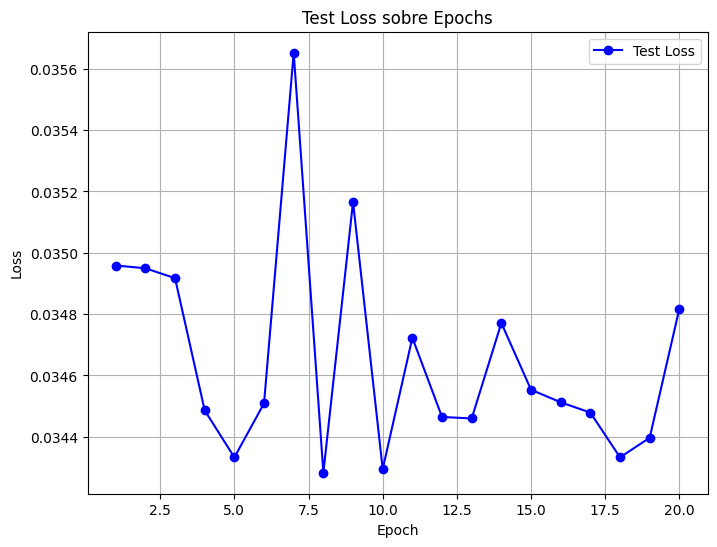

In [39]:
# Plot de los resultados
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()

# Calcular metricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.15282862975880937
RMSE de testeo fue: 0.1867212547071776
MAPE de testeo fue: inf
R2 de testeo fue: 0.1027845638020688


C:\Users\Martin\AppData\Local\Temp\ipykernel_8088\10782513.py:8: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


Dado que este modelo tambien tuvo muy buenos resultados en comparación con los demás tambien sera almacenado

In [41]:
model_save_path = "models/musicnet_pca_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/musicnet_pca_model.pth
